# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [6]:
def plot_max(accuracy_scores,variable,score,max_accuracy):
    plt.plot(accuracy_scores[variable], accuracy_scores[score])
    plt.plot( max_accuracy[variable],max_accuracy[score],'ro')
    plt.annotate('maximo: \n'+
                variable+': '+str(round(max_accuracy[variable],3))+'\n'+
                score+': '+str(round(max_accuracy[score],3)),
                 xy=( max_accuracy[variable],max_accuracy[score]),
                 xycoords='data',
                 xytext=(20, -70), textcoords='offset points', 
                 bbox=dict(boxstyle="round", fc="0.8"),
                 arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"))
    plt.xlabel(variable)
    plt.ylabel(score)


def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
    
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    ## Gini busca separar en dos grupos lo mas diferente posibles
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [7]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)
y_pred=tree_predict(X_test, tree)

In [8]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))
print('f1-score:',metrics.f1_score(y_pred, y_test))

Accuracy: 0.8433179723502304
f1-score: 0.8667711598746082


In [9]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': [1, 33000.0],
      'n_samples': 23,
      'gain': 0.03456656764785304,
      'sl': {'y_pred': 0,
       'y_prob': 0.05555555555555555,
       'level': 6,
       'split': -1,
       'n_sam

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [10]:
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
len(samples)

10

In [11]:
from sklearn.tree import DecisionTreeClassifier
y_pred_df = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

trees = {}
for i in range(10):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=None, num_pct=10)
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)
print("F1-score:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1-score: 0.8852963818321785
Accuracy: 0.8626728110599078


Con el bagged aumentó la precisión

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [54]:
def tree_grow_random(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=8):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0, random_index=-1)
        return tree
    
    
   
    # Calculate the best split  
    if max_features is None:
        j, split, gain = best_split(X, y, num_pct)  
        sample_index=None
    else:
        sample_index = np.random.choice(a=X.shape[1], size=max_features, replace=False)
        X_sample=X.iloc[:, sample_index]
        j, split, gain = best_split(X_sample, y, num_pct)
        j=sample_index[j]
        
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level,  random_index=sample_index,split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    tree['random_index']=sample_index
    # Next iteration to each split
    
    tree['sl'] = tree_grow_random(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow_random(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [56]:
tree=tree_grow_random(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=4)
y_pred=tree_predict(X_test, tree)
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8649769585253456


In [57]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'random_index': array([8, 2, 7, 0]),
 'split': [0, 2014.0],
 'n_samples': 8810,
 'gain': 0.2302237574807685,
 'sl': {'y_pred': 0,
  'y_prob': 0.08339247693399574,
  'level': 1,
  'random_index': array([4, 8, 2, 1]),
  'split': [1, 44744.72727272727],
  'n_samples': 2816,
  'gain': 0.025120355275051603,
  'sl': {'y_pred': 0,
   'y_prob': 0.437984496124031,
   'level': 2,
   'random_index': array([8, 3, 7, 6]),
   'split': [8, 1.0],
   'n_samples': 256,
   'gain': 0.029533977052359384,
   'sl': {'y_pred': 0,
    'y_prob': 0.3901345291479821,
    'level': 3,
    'random_index': array([3, 4, 7, 2]),
    'split': [2, 1.0],
    'n_samples': 221,
    'gain': 0.0325332434708166,
    'sl': {'y_pred': 0,
     'y_prob': 0.3482587064676617,
     'level': 4,
     'random_index': array([6, 3, 2, 5]),
     'split': [3, 1.0],
     'n_samples': 199,
     'gain': 0.008684167569044221,
     'sl': {'y_pred': 0,
      'y_prob': 0.40707964601769914,

In [15]:
feature_range = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for feature in feature_range:
    tree=tree_grow_random(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=feature)
    y_pred=tree_predict(X_test, tree)
    accuracy_scores.append([feature, metrics.accuracy_score(y_pred, y_test)])
    
accuracy_scores=pd.DataFrame(accuracy_scores, columns=['n_feature', 'Accuracy']) 
max_accuracy=accuracy_scores.loc[accuracy_scores['Accuracy'].idxmax()]
print('Max score:\n',max_accuracy)

Max score:
 n_feature    6.000000
Accuracy     0.872811
Name: 5, dtype: float64


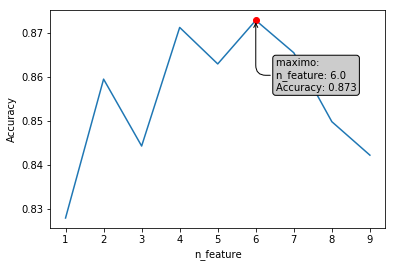

In [16]:
plot_max(accuracy_scores,'n_feature','Accuracy',max_accuracy)


Se hacen varias repeticiones para cada valor de features:

In [18]:
feature_range = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for feature in feature_range:   
    accuracy_score_feature = []
    for i in range(5):      
        tree=tree_grow_random(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=feature)
        y_pred=tree_predict(X_test, tree)
        accuracy_score_feature.append(metrics.accuracy_score(y_pred, y_test))
        
    accuracy_scores.append([feature, np.mean(accuracy_score_feature)])


accuracy_scores=pd.DataFrame(accuracy_scores, columns=['n_feature', 'Accuracy']) 
max_accuracy=accuracy_scores.loc[accuracy_scores['Accuracy'].idxmax()]
print('Max score:\n',max_accuracy)

Max score:
 n_feature    5.000000
Accuracy     0.869078
Name: 4, dtype: float64


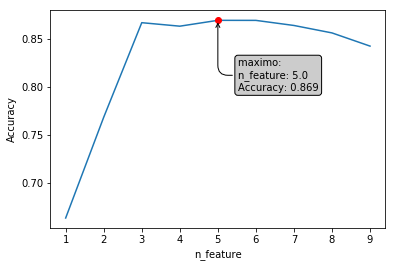

In [19]:
plot_max(accuracy_scores,'n_feature','Accuracy',max_accuracy)


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [20]:
## Boostrap
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

y_pred_df = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])
trees = {}

for i in range(10):
    trees[i] = tree_grow_random(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=int(np.log(X.shape[1])))
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

## Majority voting ans Accuracy score
y_pred = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)
print("F1-score:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1-score: 0.8886474741988051
Accuracy: 0.8582949308755761


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [25]:

clf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("F1-score:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1-score: 0.8615751789976134
Accuracy: 0.83963133640553


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

### n_estimators

In [26]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)
# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []
# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append([estimator, cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()])
    
    
accuracy_scores=pd.DataFrame(accuracy_scores, columns=['estimator', 'Accuracy']) 
max_accuracy=accuracy_scores.loc[accuracy_scores['Accuracy'].idxmax()]
print('Max score:\n',max_accuracy)

Max score:
 estimator    20.000000
Accuracy      0.839618
Name: 1, dtype: float64


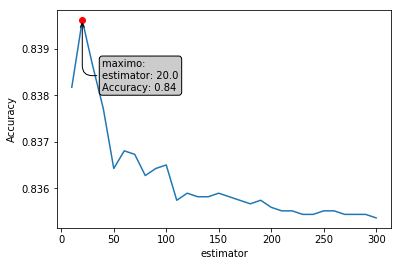

In [27]:
plot_max(accuracy_scores,'estimator','Accuracy',max_accuracy)

### max_features

In [28]:
# list of values to try for n_estimators
feature_range = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []
# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)

for feature in feature_range:
    clf = RandomForestClassifier(max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append([feature, cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()])
    
    
accuracy_scores=pd.DataFrame(accuracy_scores, columns=['n_feature', 'Accuracy']) 
max_accuracy=accuracy_scores.loc[accuracy_scores['Accuracy'].idxmax()]
print('Max score:\n',max_accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Max score:
 n_feature    9.000000
Accuracy     0.844334
Name: 8, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


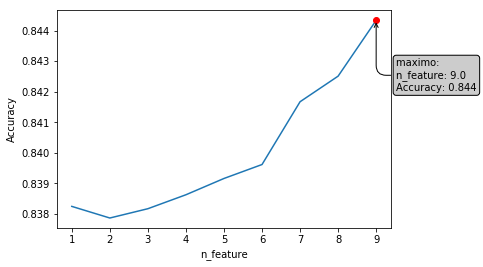

In [29]:
plot_max(accuracy_scores,'n_feature','Accuracy',max_accuracy)

### max_depth

In [30]:
# list of values to try for n_estimators
max_depth = range(1,20)
# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []
# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)

for depth in max_depth:
    clf = RandomForestClassifier( max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append([depth, cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()])
    
    
accuracy_scores=pd.DataFrame(accuracy_scores, columns=['depth', 'Accuracy']) 
max_accuracy=accuracy_scores.loc[accuracy_scores['Accuracy'].idxmax()]
print('Max score:\n',max_accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Max score:
 depth       8.000000
Accuracy    0.881369
Name: 7, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


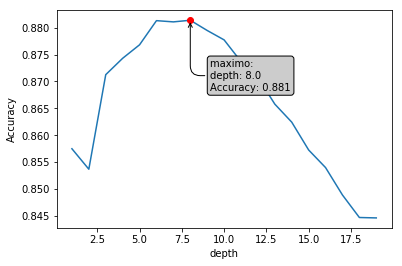

In [58]:
plot_max(accuracy_scores,'depth','Accuracy',max_accuracy)

### Mejores  parámetros

In [32]:
clf = RandomForestClassifier(n_estimators=20, max_features=9,max_depth=9, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("F1-score:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1-score: 0.896046287367406
Accuracy: 0.8758064516129033


In [33]:
# compute feature importances
feature_cols = X_train.columns
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000039
3,M_Camry4dr,0.000504
7,M_CamrySE,0.003372
5,M_CamryL,0.004247
8,M_CamryXLE,0.010379
2,M_Camry,0.010591
6,M_CamryLE,0.018174
0,Year,0.141538
1,Mileage,0.811158
